# **Credit Card Fraud Detection using Random Forest + SMOTE**

---

**Google Drive Access Setup**

In [0]:
import warnings
warnings.filterwarnings('ignore')

# Only need to run this cell when using Google Colab
# Reading data from google drive
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticating and creating the Drive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

df = drive.CreateFile({'id':'1hZqu_ZwU6ktSwkwDVWX9hs1WUDWKFdez'}) 
df.GetContentFile('creditcard.csv')

**Dataset Import**

The dataset can be downloaded from Kaggle. It contains data about credit card transactions that occurred during a period of two days, with 492 frauds out of 284,807 transactions.

All variables in the dataset are numerical. The data has been transformed using PCA transformation(s) due to privacy reasons. The two features that haven’t been changed are Time and Amount. Time contains the seconds elapsed between each transaction and the first transaction in the dataset.

In [0]:
# Data can be downloaded from https://www.kaggle.com/mlg-ulb/creditcardfraud/download
# Loading the dataset from the csv file using pandas
import pandas as pd
data = pd.read_csv('creditcard.csv')

**Understanding the Data Dataset**

In [0]:
# Exploring the Dataset
# Print the shape of the data
print('This data frame has {} rows and {} columns.'.format(data.shape[0], data.shape[1]))

This data frame has 284807 rows and 31 columns.


In [0]:
# Printing the columns of the data
print(data.columns)

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')


In [0]:
# #let's take a peek at the data
data

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


Due to some confidentiality issues, the original features are replaced with V1, V2, … V28 columns which are the result of PCA transformation applied to the original ones. 

The only features which have not been transformed with PCA are ‘Time’ and ‘Amount’. Feature ‘Class’ is the response variable and it takes value 1 in case of fraud and 0 otherwise.

**Time:** Number of seconds elapsed between this transaction and the first transaction in the dataset.

**Amount:** Transaction amount

**Class:** 1 for fraudulent transactions, 0 otherwise

In [0]:
# Information about the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [0]:
print(data.describe())
# V1 - V28 are the results of a PCA Dimensionality reduction to protect user identities and sensitive features

                Time            V1  ...         Amount          Class
count  284807.000000  2.848070e+05  ...  284807.000000  284807.000000
mean    94813.859575  3.919560e-15  ...      88.349619       0.001727
std     47488.145955  1.958696e+00  ...     250.120109       0.041527
min         0.000000 -5.640751e+01  ...       0.000000       0.000000
25%     54201.500000 -9.203734e-01  ...       5.600000       0.000000
50%     84692.000000  1.810880e-02  ...      22.000000       0.000000
75%    139320.500000  1.315642e+00  ...      77.165000       0.000000
max    172792.000000  2.454930e+00  ...   25691.160000       1.000000

[8 rows x 31 columns]


In [0]:
# Null value check
data.isnull().values.any()

False

In [0]:
data["Class"].unique() # 0 = Fraud , 1 = Normal Transaction

array([0, 1])

**Fraud vs. Valid Transactions**

In [0]:
# Fraud vs. Valid Transactions 
counts = data.Class.value_counts()
valid = counts[0]
fraud = counts[1]
perc_valid = (valid/(valid+fraud))*100
perc_fraud = (fraud/(valid+fraud))*100
print('Valid Transactions = {} & Percentage {:.3f}%.'.format(valid, perc_valid,))
print('Fraud = {} & Percentage {:.3f}%.'.format(fraud, perc_fraud))

Valid Transactions = 284315 & Percentage 99.827%.
Fraud = 492 & Percentage 0.173%.


In [0]:
Fraud = data[data['Class'] == 1]
Valid = data[data['Class'] == 0]

In [0]:
print("Amount details of fraud")
Fraud.Amount.describe()

Amount details of fraud


count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [0]:
print("Amount details of valid transaction")
Valid.Amount.describe()

Amount details of valid transaction


count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

As we can clearly notice from this, the average (mean) Money transaction for the fraudulent ones are more. This makes this problem crucial to deal with.

**Visualizing the Dataset**

Text(0.5, 0, 'Class (0:Valid, 1:Fraud)')

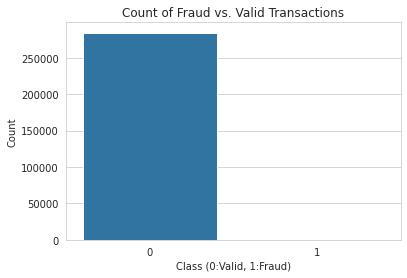

In [0]:
# Visualizing the dataset
import matplotlib.pyplot as plt
import seaborn as sns
sns.countplot(data['Class'], label = "Count")
plt.title('Count of Fraud vs. Valid Transactions')
plt.ylabel('Count')
plt.xlabel('Class (0:Valid, 1:Fraud)')
# Data is extremely unbalanced


**2-D Scatter Plot**

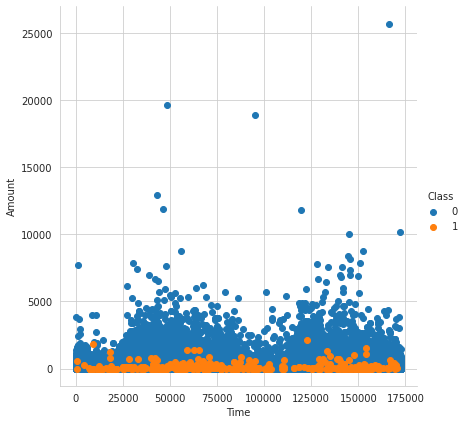

In [0]:
sns.set_style("whitegrid")
sns.FacetGrid(data, hue="Class", height = 6).map(plt.scatter, "Time", "Amount").add_legend()
plt.show()

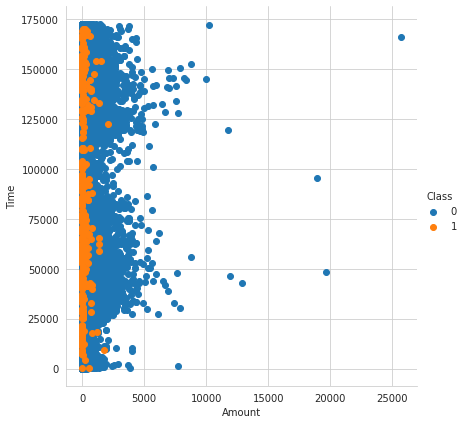

In [0]:
sns.set_style("whitegrid")
sns.FacetGrid(data, hue="Class", height = 6).map(plt.scatter, "Amount", "Time").add_legend()
plt.show()

**Observations**

1.   From the above two plots it is clearly visible that there are frauds only on the transactions which have transaction amount approximately less than 2500. Transactions which have transaction amount approximately above 2500 have no fraud.
2.   As per with the time, the frauds in the transactions are evenly distributed throughout time.



Text(0.5, 1.0, 'Heatmap of Correlation')

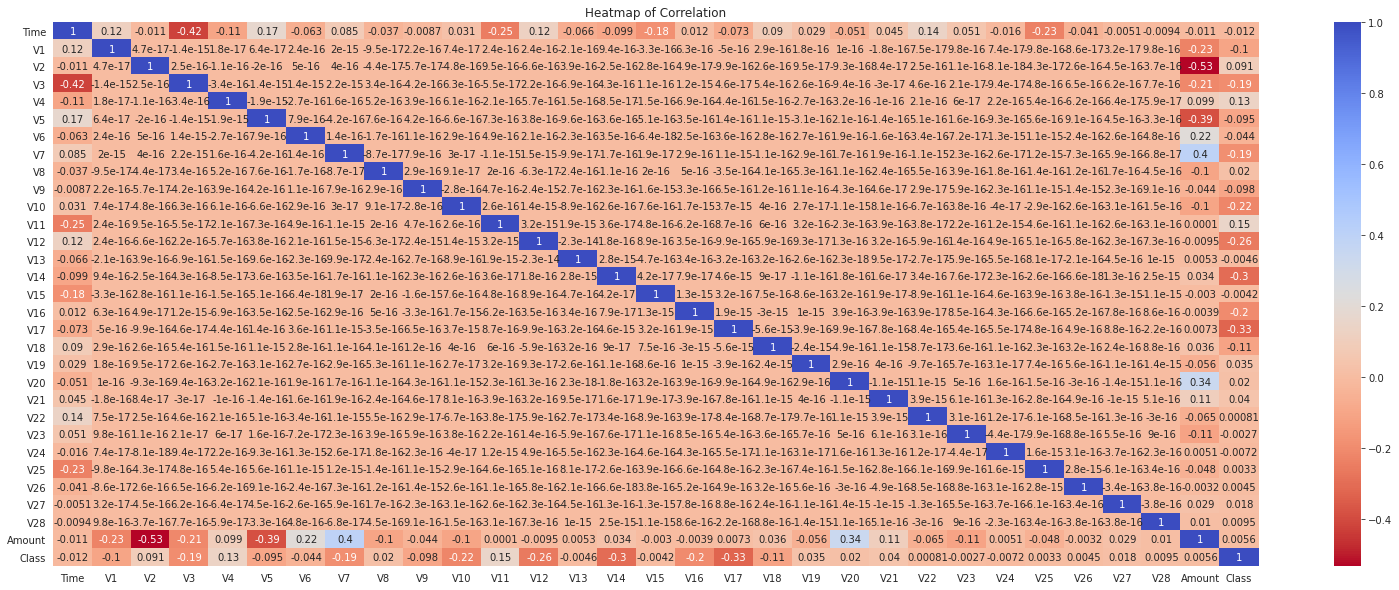

In [0]:
# A beautiful correlation matrix using seaborn
import seaborn as sb  # Create high quality heatmaps
plt.figure(figsize=(27,10))
sb.heatmap(data.corr(), annot=True, cmap='coolwarm_r')
plt.title('Heatmap of Correlation')

**Correlation Matrices**

Correlation matrix graphically gives us an idea of how features correlate with each other and can help us predict what are the features that are most relevant for the prediction. We want to know if there are features that influence heavily in whether a specific transaction is a fraud. 

In the HeatMap we can clearly see that most of the features do not correlate to other features but there are some features that either has a positive or a negative correlation with each other. For example “V2” and “V5” are highly negatively correlated with the feature called “Amount”. We also see some correlation with “V20” and “Amount”. This gives us a deeper understanding of the Data available to us.

In [0]:
# Seperating the X and the Y from the dataset
X = data.drop(['Class'], axis=1)
Y = data["Class"]
print(X.shape)
print(Y.shape)

# Getting just the values for the sake of processing (its a numpy array with no columns)
X_data=X.values
Y_data=Y.values

(284807, 30)
(284807,)


**Splitting the Data into Train and Test Datasets using 80:20 mix**

The model will be built on training data and will be applied on the test data

In [0]:
# Using Scikit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=0.2, random_state = 42)

In [0]:
import numpy as np

# Let's get an idea of what our data looks like
print('Training instances of data:',len(Y_train))
print('Training instances of fraud:',np.count_nonzero(Y_train))
print('Testing instances of data:',len(Y_test))
print('Testing instances of fraud:',np.count_nonzero(Y_test))

Training instances of data: 227845
Training instances of fraud: 394
Testing instances of data: 56962
Testing instances of fraud: 98


**A brief about the Random Forest Algorithm**

Random forest classifier creates a set of decision trees from randomly selected subset of training set. It then aggregates the votes from different decision trees to decide the final class of the test object. 

Random forests or random decision forests are an ensemble learning method for classification, regression and other tasks, that operate by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees. Random decision forests will avoid overfitting which will enhance the accuracy of the model on new data. 

**Building the Random Forest Model using the Original Imbalanced Dataset**

In [0]:
# Train and test using the original imbalanced dataset
from sklearn.ensemble import RandomForestClassifier

# Random Forest Model Creation
rfc = RandomForestClassifier()
rfc.fit(X_train,Y_train)
print('Model:',rfc)

# Predictions
Y_pred = rfc.predict(X_test)

Model: RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


**Evaluation**

**Accuracy:**  It is the number of correct predictions made divided by the total number of predictions made.

**Area Under the Curve:** A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate. High scores for both show that the classifier is returning accurate results (high precision), as well as returning a majority of all positive results (high recall)

Precision and recall are defined as follows:

**Precision** = (True Positives + False Positives)/True Positives

**Recall** = (True Positives + False Negatives)/True Ppositives


**Precision** measures the relevancy of obtained results. **Recall**, on the other hand, measures how many relevant results are returned. Both values can take values between 0 and 1. We would love to have a system with both values being equal to 1.

**F1 Score:** F1 score is a measure of a test's accuracy. Put another way, the F1 score conveys the balance between the precision and the recall.

**F1 Score** = 2*((precision*recall)/(precision+recall))

In [0]:
# Evaluating The Model Random Forest
from sklearn import metrics

print('Confusion Matrix\n ',metrics.confusion_matrix(Y_test, Y_pred))
print('\n Classification Report\n ')
print(metrics.classification_report(Y_test, Y_pred))

print('\nAccuracy : %f' % (metrics.accuracy_score(Y_test, Y_pred)))
print('Area under the curve : %f' % (metrics.roc_auc_score(Y_test, Y_pred)))
print("Precision : %f" % (metrics.precision_score(Y_test,Y_pred)))
print("Recall :  %f" % (metrics.recall_score(Y_test,Y_pred)))
print("F1-Score : %f" % (metrics.f1_score(Y_test,Y_pred)))

Confusion Matrix
  [[56862     2]
 [   21    77]]

 Classification Report
 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.97      0.79      0.87        98

    accuracy                           1.00     56962
   macro avg       0.99      0.89      0.93     56962
weighted avg       1.00      1.00      1.00     56962


Accuracy : 0.999596
Area under the curve : 0.892840
Precision : 0.974684
Recall :  0.785714
F1-Score : 0.870056


**Confusion Matrix**

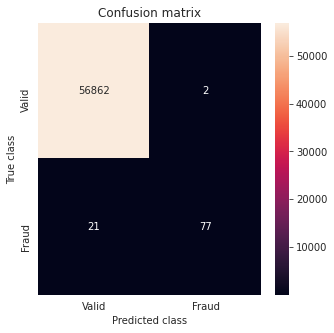

In [0]:
# Printing the confusion matrix
from sklearn.metrics import confusion_matrix

LABELS = ['Valid', 'Fraud']
conf_matrix = confusion_matrix(Y_test, Y_pred)
plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

**Visualizing the Random Tree**

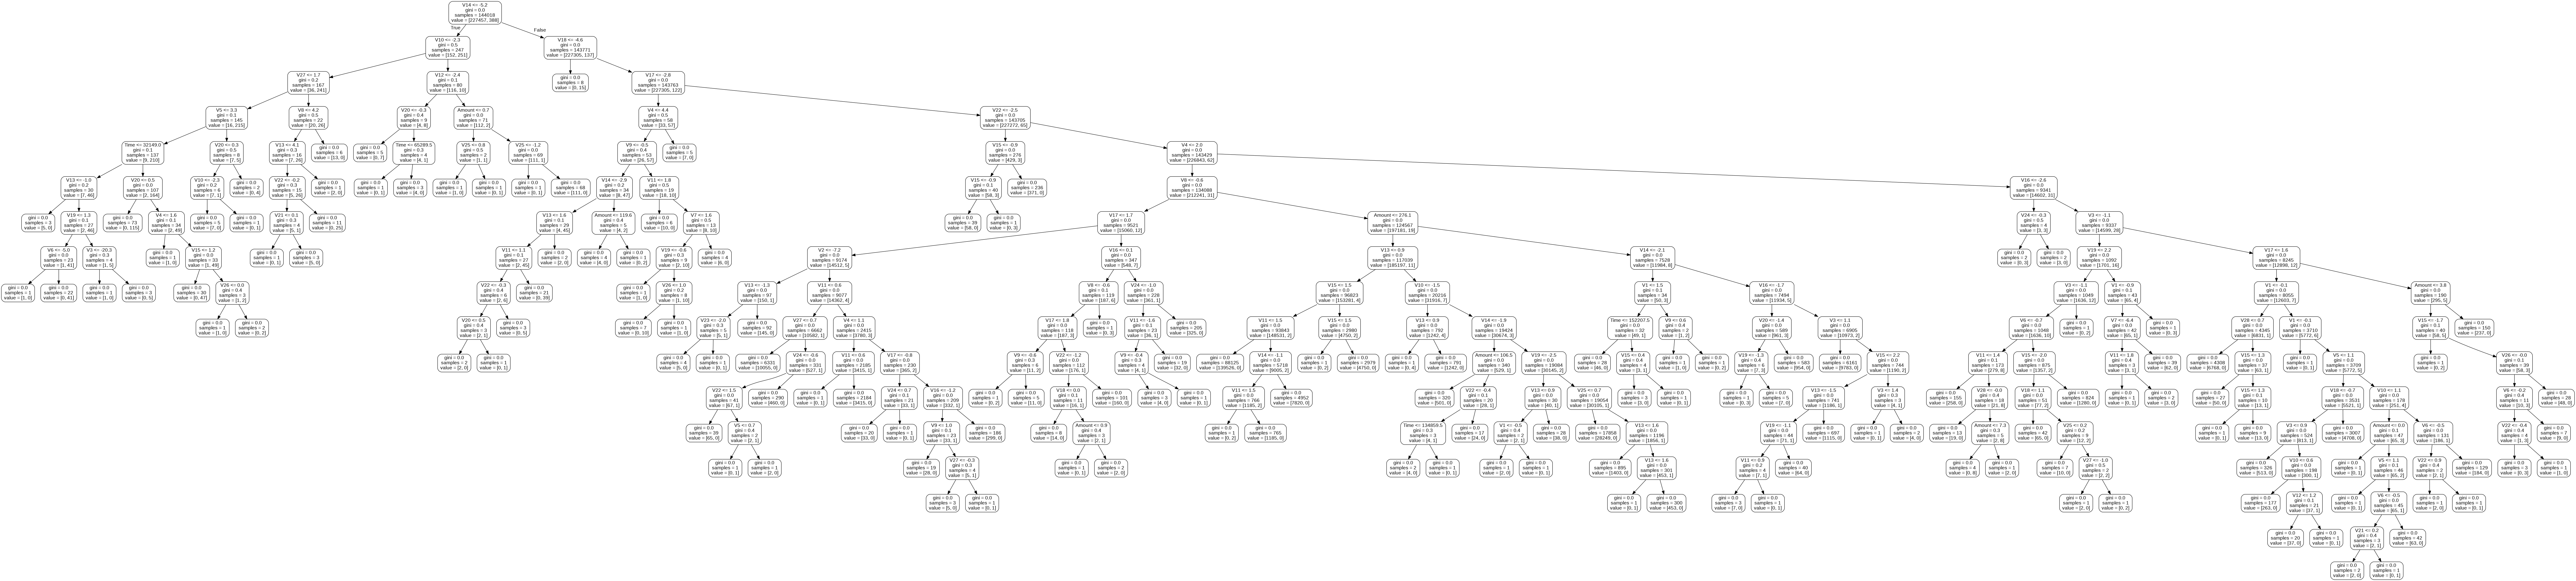

In [0]:
# Visualizing the random tree 
feature_list = list(X.columns)

# Import tools needed for visualization
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydot

# Pulling out one tree from the forest
tree = rfc.estimators_[5]
export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_list, rounded = True, precision = 1)

# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')

# Write graph to a png file
display(Image(graph.create_png()))

**Balancing the classes**

The Dataset is highly Unbalanced as there is only 0.17% fraudulent transaction out of all the transactions. SMOTE (Synthetic Minority Over-sampling Technique) is implemented for a more balanced dataset to feed our model.

In [0]:
#Train and test using SMOTE oversampled dataset
import numpy as np
from imblearn.over_sampling import SMOTE

# Implementing Synthetic Minority Over-sampling Technique for a more balanced dataset to feed the model
X_resample, Y_resample = SMOTE(sampling_strategy='minority').fit_resample(X_train, Y_train)

# Let's get an idea of what our new oversampled data looks like
print('Training instances of data:',len(Y_resample))
print('Training instances of fraud:',np.count_nonzero(Y_resample))
print('Testing instances of data:',len(Y_test))
print('Testing instances of fraud:',np.count_nonzero(Y_test))

Training instances of data: 454902
Training instances of fraud: 227451
Testing instances of data: 56962
Testing instances of fraud: 98


**Building the Random Forest Model using SMOTE oversampled dataset**

In [0]:
# Random Forest Model Creation
rfc.fit(X_resample,Y_resample)

print('Model:',rfc)

# Predictions
Y_pred_smote = rfc.predict(X_test)

Model: RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


**Evaluation**

In [0]:
# Evaluating The Model Random Forest + SMOTE
print('Confusion Matrix\n ',metrics.confusion_matrix(Y_test, Y_pred_smote))
print('\n Classification Report\n ')
print(metrics.classification_report(Y_test, Y_pred_smote))

print('\nAccuracy : %f' % (metrics.accuracy_score(Y_test, Y_pred_smote)))
print('Area under the curve : %f' % (metrics.roc_auc_score(Y_test, Y_pred_smote)))
print("Precision : %f" % (metrics.precision_score(Y_test,Y_pred_smote)))
print("Recall :  %f" % (metrics.recall_score(Y_test,Y_pred_smote)))
print("F1-Score : %f" % (metrics.f1_score(Y_test,Y_pred_smote)))

Confusion Matrix
  [[56851    13]
 [   14    84]]

 Classification Report
 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.87      0.86      0.86        98

    accuracy                           1.00     56962
   macro avg       0.93      0.93      0.93     56962
weighted avg       1.00      1.00      1.00     56962


Accuracy : 0.999526
Area under the curve : 0.928457
Precision : 0.865979
Recall :  0.857143
F1-Score : 0.861538


**Confusion Matrix**

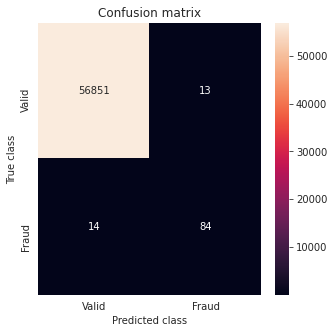

In [0]:
# Printing the confusion matrix
LABELS = ['Valid', 'Fraud']
conf_matrix = confusion_matrix(Y_test, Y_pred_smote)
plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

**Visualizing the Random Tree**

In [0]:
# Visualizing the random tree 
feature_list = list(X.columns)

# Pulling out one tree from the forest
tree = rfc.estimators_[5]
export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_list, rounded = True, precision = 1)

# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')

# Write graph to a png file
display(Image(graph.create_png()))

Output hidden; open in https://colab.research.google.com to view.

**Conclusion**

We have managed to deal with the unbalancing of data using SMOTE.

In Random Forest Model using SMOTE oversampled, recall score increases from .79 to .85. Gives us overall good scores.

The model is fast, it is definitely simple and most importantly easily interpretable as shown in the Decision Tree diagram. 